# 07. Function Inference

Author: Minghang Li

In this Jupyter Notebook, we perform function inference using the `picrust2`
plugin based on amplicon-based sequencing results.

<div style="background-color: lightsalmon; padding: 10px;">
    
**NOTE**: `q2-picrust2` plugin is not directly compatible with `qiime2-2024.10` as of now. We need to manually install the plugin from source and modify `setup.py` to make it compatible with the current version of `qiime2`.
</div>



**Notebook overview**<br>
[1. Setup](#1-setup)<br>
[2. Run `picrust2` full pipeline](#2-run-picrust2-full-pipeline)<br>
[3. Analysis and Visualization](#3-visualization)<br>
[4. Thoughts and discussion](#4-thoughts-and-discussion)<br>

## 1. Setup

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path

%matplotlib inline

In [2]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

## 2. Run `picrust2` full pipeline

PICRUSt2 (Phylogenetic Investigation of Communities by Reconstruction of Unobserved States) is a software for predicting functional abundances based only on marker gene (here, it's 16S rRNA) sequences.

"Function" here refers to gene families such as KEGG orthologs (KO), Enzyme Classification (EC) numbers, and metabolic (MetaCyc) pathways.

Here we use **maximum parsimony** (`mp`) for hidden state predcition (HSP) and **SEPP** (SATé-Enabled Phylogenetic Placement) method for tree placement (cannot use `EPA-NG` due to limited RAM + trying to be consistent with `q2-feature-insertion`). `--p-edge-exponent` was set to be `0` for the pipeline to run successfully (as SEPP handles branch weighing internally)

<div style="background-color: aliceblue; padding: 10px;">

**NOTE** `qiime picrust2 custom-tree-pipeline` can only use trees built from `qiime fragment-insertion sepp` as an input. So the tree built in `03_phylogeny.ipynb` cannot be used.
</div>

In [ ]:
! qiime picrust2 full-pipeline \
    --i-table $data_dir/table-filtered.qza \
    --i-seq $data_dir/rep-seqs-filtered.qza \
    --p-threads 16 \
    --p-hsp-method mp \
    --p-edge-exponent 0 \
    --p-placement-tool sepp \
    --output-dir $data_dir/q2-picrust2_fullpipeline \
    --verbose

## 3. Downstream Analysis and Visualization


In [3]:
picrust_res = data_dir / "q2-picrust2_fullpipeline"

### 3.1 Summarize the table

Summarize the information using `feature-table summarize`

In [4]:
! qiime feature-table summarize \
   --i-table $picrust_res/ko_metagenome.qza \
   --o-visualization $picrust_res/ko_metagenome.qzv

! qiime feature-table summarize \
   --i-table $picrust_res/ec_metagenome.qza \
   --o-visualization $picrust_res/ec_metagenome.qzv

! qiime feature-table summarize \
   --i-table $picrust_res/pathway_abundance.qza \
   --o-visualization $picrust_res/pathway_abundance.qzv

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/ko_metagenome.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/ec_metagenome.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/pathway_abundance.qzv


In [5]:
Visualization.load(f"{picrust_res}/ko_metagenome.qzv")

<visualization: Visualization uuid: 9cd5edf0-56a5-43aa-94c9-2b3c028fe41c>

In [29]:
Visualization.load(f"{picrust_res}/ec_metagenome.qzv")

<visualization: Visualization uuid: d5c7f04f-a737-4c53-948b-653d760ee61c>

In [30]:
Visualization.load(f"{picrust_res}/pathway_abundance.qzv")

<visualization: Visualization uuid: 5a8f31d6-c765-4501-8ec5-f786e609da69>

### 3.2 Compute diversity

#### 3.2.1 KEGG

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/ko_metagenome.qza \
    --p-max-depth 30000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/ko_metagenome/alpha-rarefaction-ko.qzv

In [16]:
! qiime diversity core-metrics \
   --i-table $picrust_res/ko_metagenome.qza \
   --p-sampling-depth 10000 \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/ko_metagenome_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/bray_curtis_pcoa_results.qza


In [6]:
ko = q2.Artifact.load(picrust_res / "ko_metagenome.qza").view(pd.DataFrame)
ko.head()

,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,K00012,...,K19744,K19745,K19746,K19775,K19776,K19777,K19778,K19780,K19784,K19789
EG0024,29595.76,0.0,164935.50,546.25,27661.88,92.69,473551.33,4580.44,229425.13,160271.21,...,0.0,142.69,0.0,56.69,134.69,0.00,0.00,0.0,85.58,142.69
EG0031,3060.39,0.0,1539.26,70880.50,132233.35,74481.19,601.16,129770.24,277973.09,128340.65,...,10.0,128234.94,10.0,57555.94,114543.94,4.75,4.75,0.0,55974.44,128234.94
EG0039,49784.60,0.0,50511.19,1872.42,17796.00,0.00,56987.94,4624.45,1956.20,22965.92,...,0.0,2886.92,0.0,2884.25,2884.25,2884.25,2884.25,0.0,44585.44,2884.25
EG0055,12084.15,0.0,182254.98,2813.66,5853.22,48.00,1348.67,175788.25,350586.32,417.83,...,0.0,91.50,0.0,43.50,91.50,6.50,6.50,0.0,403.57,91.50
EG0057,60850.38,0.0,49605.96,19489.00,31896.67,0.00,12205.59,11283.30,589.71,425.59,...,0.0,21.00,0.0,21.00,21.00,0.00,0.00,0.0,103.96,21.00


#### 3.2.2 EC counts

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/ec_metagenome.qza \
    --p-max-depth 10000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-ec.qzv

In [17]:
! qiime diversity core-metrics \
   --i-table $picrust_res/ec_metagenome.qza \
   --p-sampling-depth 10000 \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/ec_metagenome_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: ec_metagenome_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: ec_metagenome_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ec_metagenome_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ec_metagenome_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: ec_metagenome_core_metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: ec_metagenome_core_metrics/jaccard_emperor.qzv
Saved Visualization to: ec_metagenome_core_metrics/bray_curtis_emperor.qzv


In [7]:
ec = q2.Artifact.load(picrust_res / "ec_metagenome.qza").view(pd.DataFrame)
ec.head()

,EC:1.1.1.1,EC:1.1.1.100,EC:1.1.1.103,EC:1.1.1.108,EC:1.1.1.11,EC:1.1.1.122,EC:1.1.1.125,EC:1.1.1.130,EC:1.1.1.132,EC:1.1.1.133,...,EC:6.4.1.4,EC:6.4.1.5,EC:6.5.1.1,EC:6.5.1.2,EC:6.5.1.3,EC:6.5.1.4,EC:6.5.1.6,EC:6.5.1.7,EC:6.6.1.1,EC:6.6.1.2
EG0024,236290.26,211757.34,28034.02,0.00,92.69,0.00,120724.52,807.83,0.00,110040.76,...,0.00,0.0,2144.00,153940.11,471.84,0.00,0.00,0.00,768.00,643.73
EG0031,390627.67,415254.40,128251.14,213.20,74481.19,22.40,202201.77,86751.08,16.20,87347.59,...,26.20,20.0,44.80,258820.31,13716.45,4.75,16.20,16.20,31.60,21.87
EG0039,155419.10,211850.99,5925.75,265.50,0.00,23.67,7951.33,4092.25,7.17,28481.69,...,11.17,0.0,3795.02,90131.94,3309.42,2884.25,162.17,162.17,343.84,168.17
EG0055,202488.22,717906.15,136.75,2744.25,48.00,2.50,175313.00,61.50,1.25,177685.98,...,1.25,0.0,5.00,182723.73,17.00,6.50,1.25,1.25,41.74,40.08
EG0057,160530.27,165589.35,67.33,8415.00,0.00,51.00,316.00,7.00,14.00,6812.38,...,29.00,0.0,89.00,78609.63,36.75,0.00,29.00,29.00,29.00,21.67


#### 3.2.3 Path abundance

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/pathway_abundance.qza \
    --p-max-depth 5000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-pathabund.qzv

In [18]:
! qiime diversity core-metrics \
   --i-table $picrust_res/pathway_abundance.qza \
   --p-sampling-depth 5000 \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/pathway_abundance_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: pathway_abundance_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: pathway_abundance_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: pathway_abundance_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: pathway_abundance_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: pathway_abundance_core_metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: pathway_abundance_core_metrics/jaccard_emperor.qzv
Saved Visualization to: pathway_abundance_core_metrics/bray_curtis_emperor.qzv


In [8]:
pathabun = q2.Artifact.load(f"{picrust_res}/pathway_abundance.qza").view(pd.DataFrame)
pathabun.head()

,1CMET2-PWY,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,AEROBACTINSYN-PWY,ALL-CHORISMATE-PWY,ANAEROFRUCAT-PWY,ANAGLYCOLYSIS-PWY,ARG+POLYAMINE-SYN,ARGDEG-PWY,ARGORNPROST-PWY,ARGSYN-PWY,...,THISYN-PWY,THREOCAT-PWY,THRESYN-PWY,TRNA-CHARGING-PWY,TRPSYN-PWY,TYRFUMCAT-PWY,UBISYN-PWY,UDPNAGSYN-PWY,VALDEG-PWY,VALSYN-PWY
EG0024,116613.984453,73.424692,63.643626,1026.966436,27815.373858,151411.464318,2608.113398,252.180004,4558.641993,107229.507915,...,94380.275853,259.752512,110387.739891,110445.977771,105577.623217,0.000000,339.050562,34476.365984,0.0,162192.010400
EG0031,136253.349598,63725.681123,64514.001632,148867.177540,167925.553339,169866.365287,144954.170796,141759.514298,87195.474330,161750.564324,...,120603.131866,204.378689,163193.943180,142500.286816,156707.938691,26.996907,145507.073631,130545.837853,0.0,163119.763567
EG0039,77411.718837,0.000000,39.073526,5988.831451,84702.114029,103051.671420,14120.130585,4853.163308,5341.081270,33180.001699,...,16654.384958,5807.628900,43766.580400,77373.310502,33170.646036,14.660025,3782.890741,78984.024230,0.0,55215.280267
EG0055,181117.459408,43.401534,49.754902,433.312325,233345.335016,214956.294156,432.364351,143.700771,5556.457529,14290.748880,...,340.750434,192.351322,218178.886473,8956.587539,22821.853759,2.059130,143.420182,182571.575573,0.0,12403.531249
EG0057,53230.419360,32.435472,25.315068,133.563270,83460.634850,90371.770969,119.174362,41.711924,50651.344895,20611.037128,...,458.877527,72.135985,57783.902711,3151.556643,22091.600950,29.857820,40.349876,78450.424058,0.0,31334.792862


### 3.3 Visualize the results

We visualize the metagnome predictions using heatmaps, with x-axis as samples 
and y-axis as the corresponding KEGG orthologs / EC numbers / MetaCyc pathways. 
The color intensity represents the abundance of the gene family in the sample 
(log-transformed), with redder color indicating higher abundance.

#### 3.3.1 KEGG orthologs heatmap and clustermap

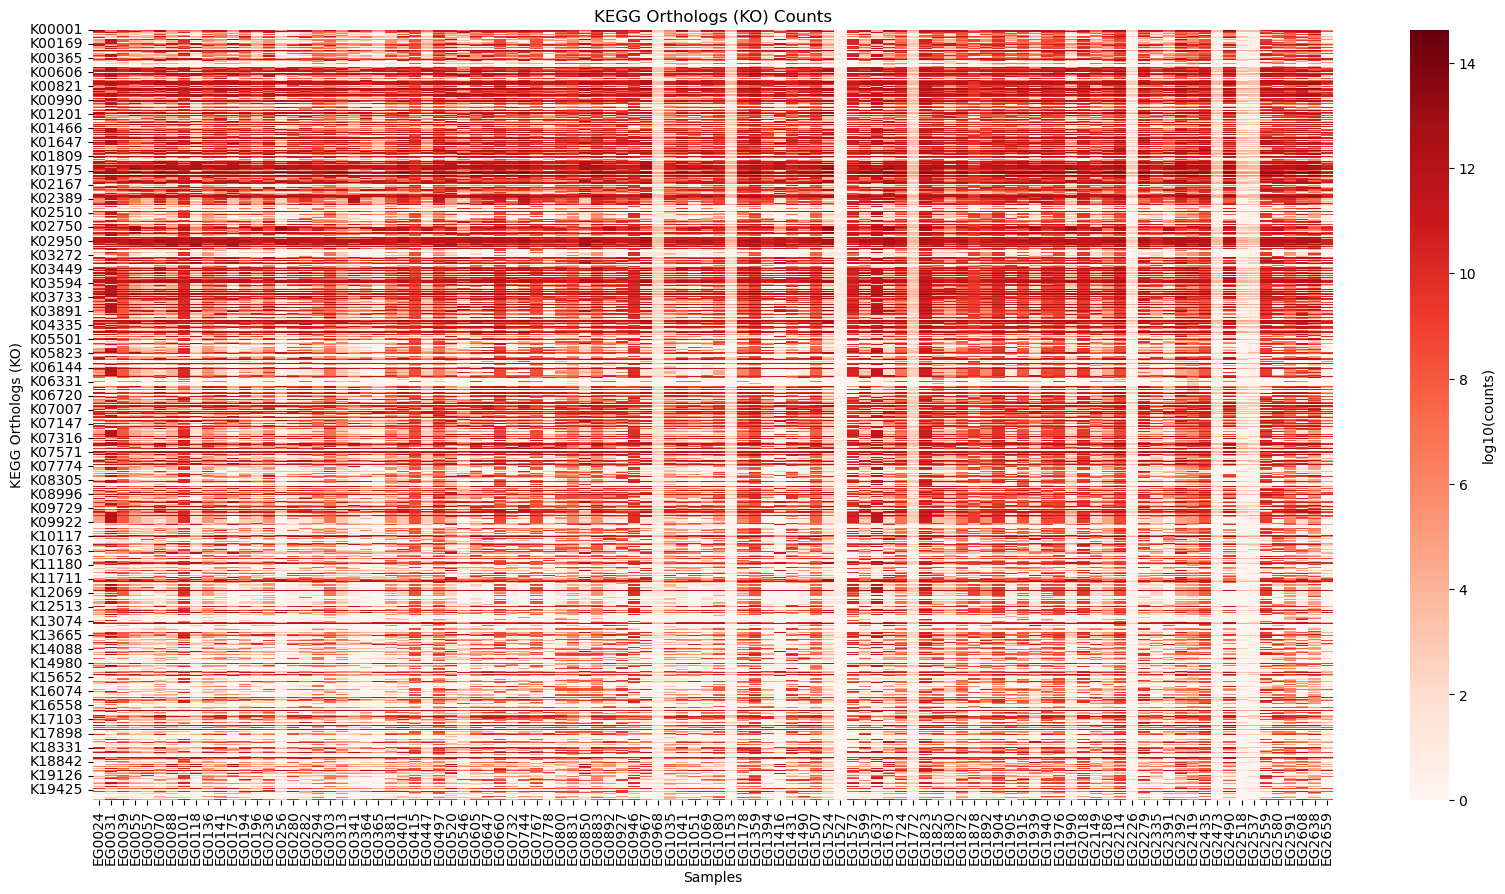

In [17]:
# Visualize KEGG orthologs - heatmap
ko_log = np.log(ko + 1)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.heatmap(ko_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, ax=ax, xticklabels=ko_log.index)
g.set_title("KEGG Orthologs (KO) Counts")
g.set_xlabel("Samples")
g.set_ylabel("KEGG Orthologs (KO)")
g.figure.savefig(vis_dir / "ko_heatmap.png")

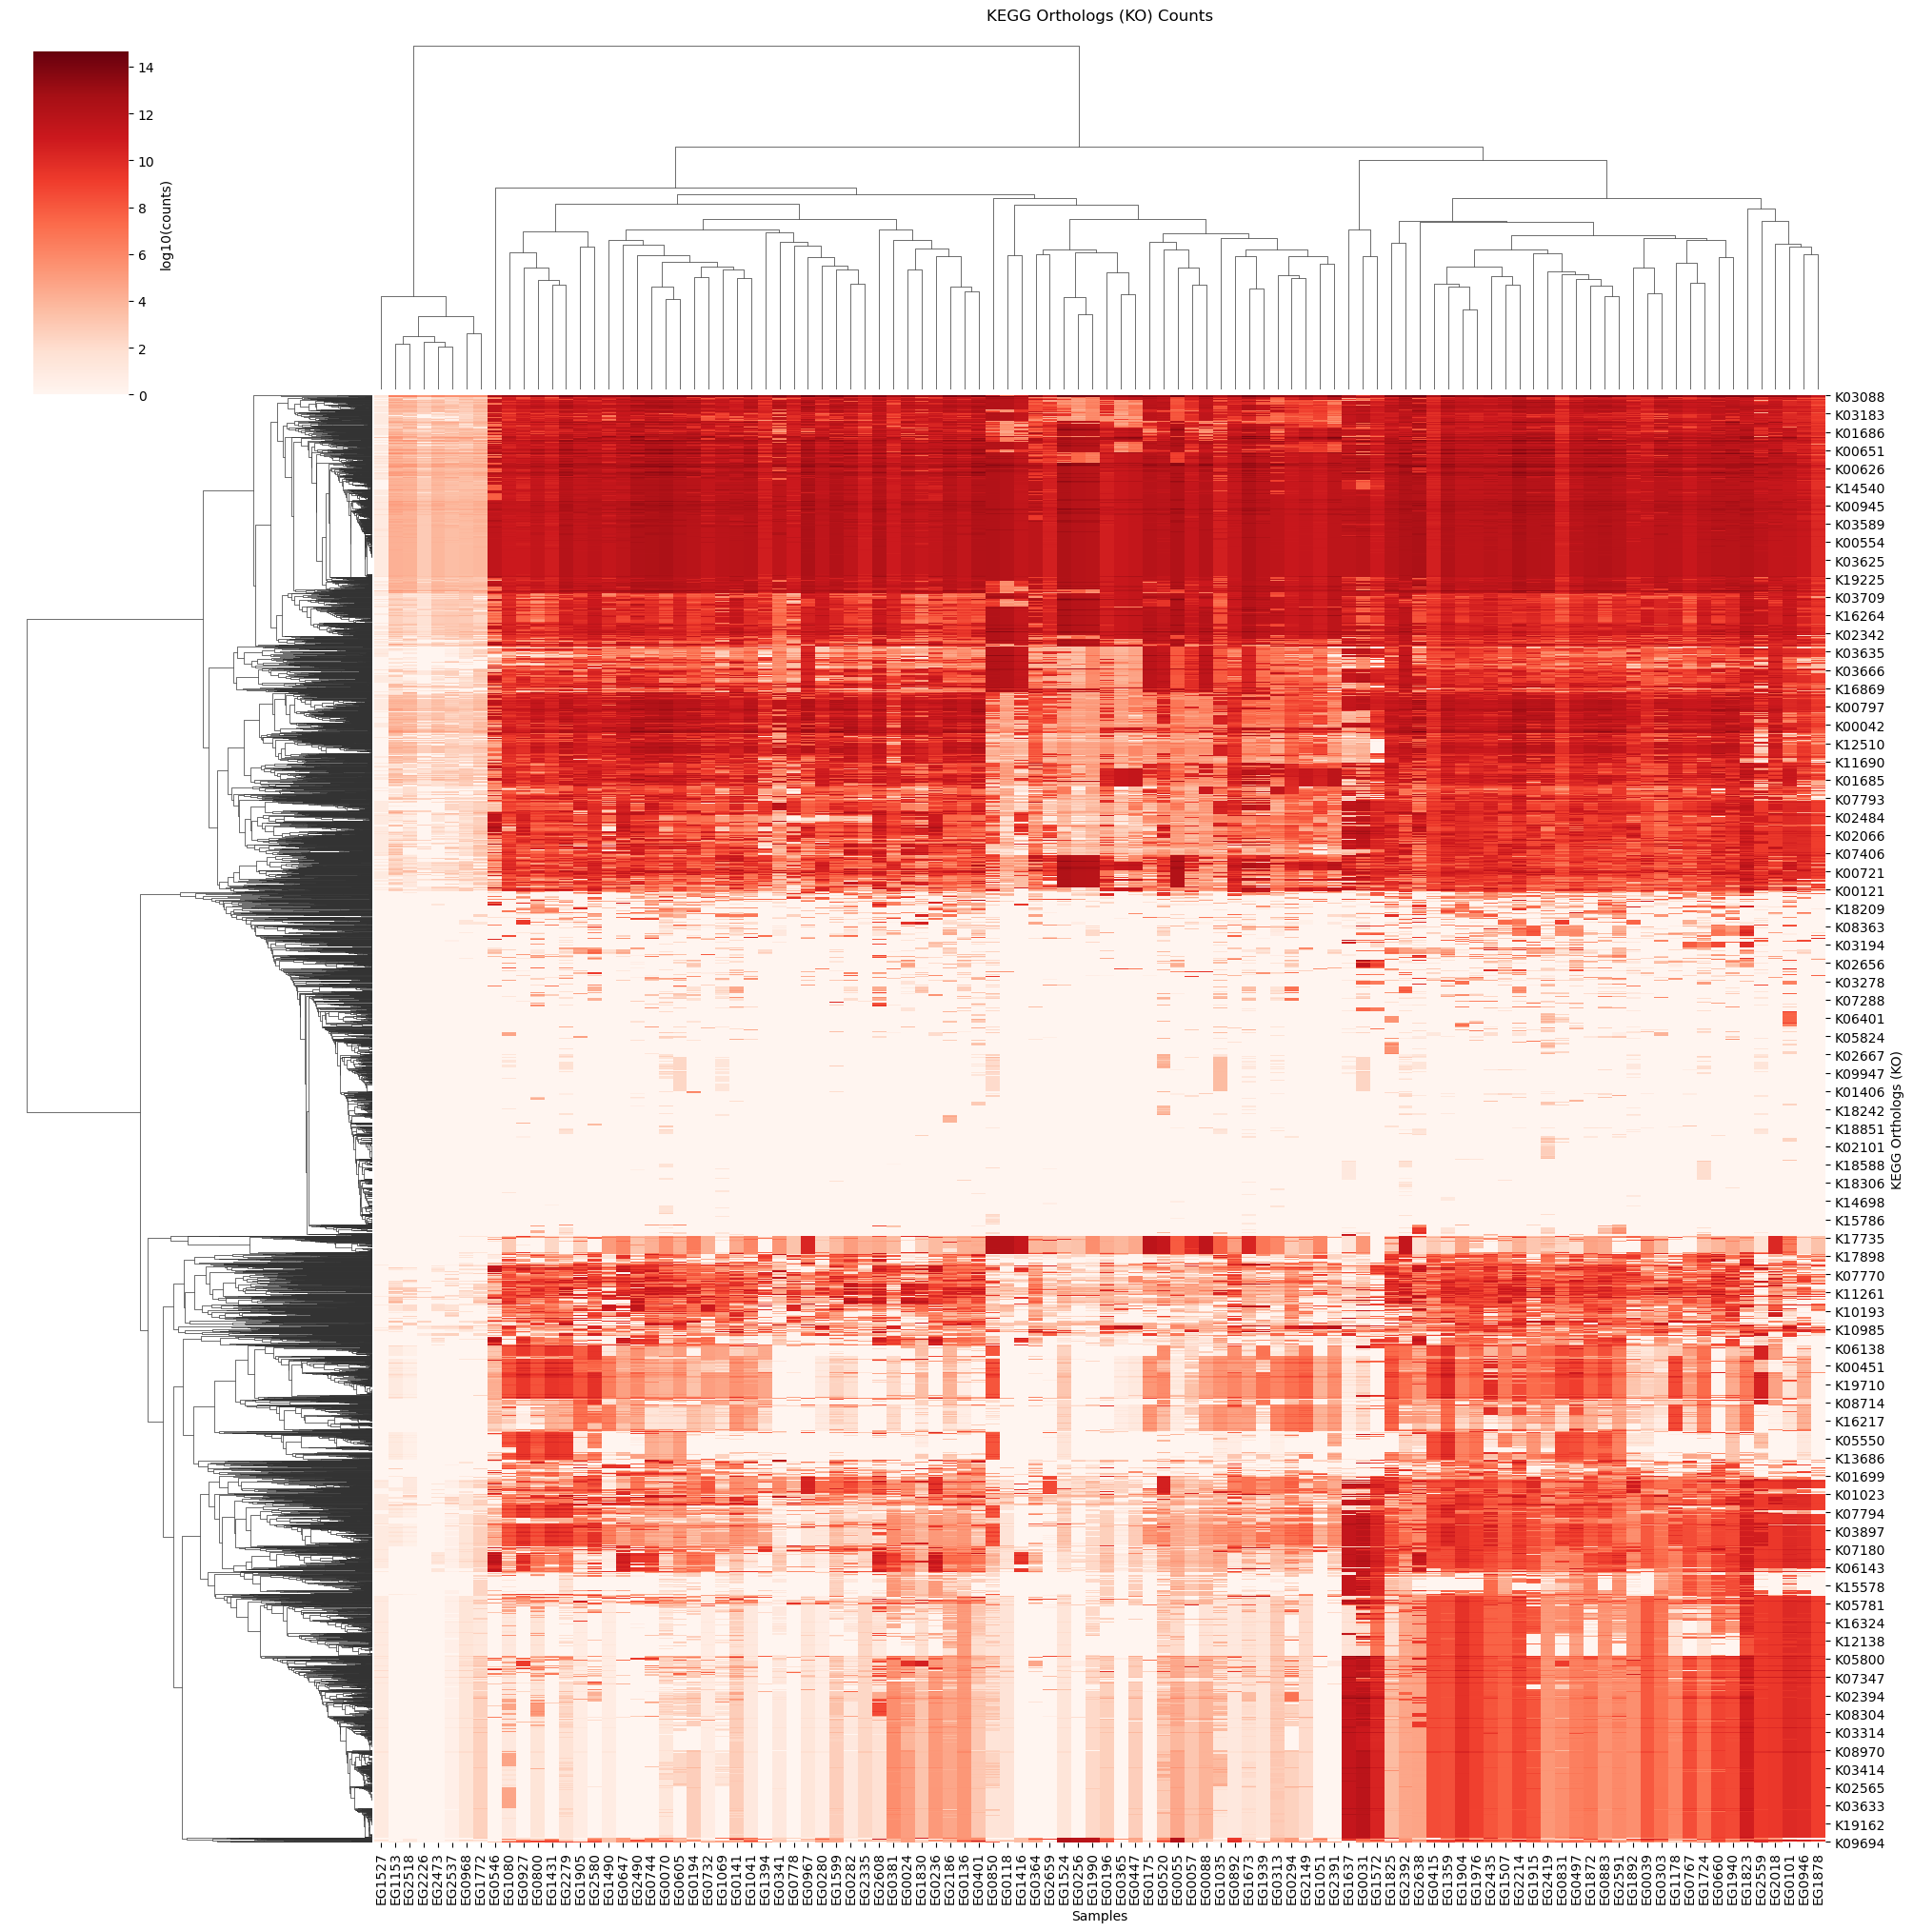

In [13]:
g = sns.clustermap(ko_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, figsize=(20, 20), xticklabels=ko_log.index)
g.ax_col_dendrogram.set_title("KEGG Orthologs (KO) Counts")
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("KEGG Orthologs (KO)")
g.savefig(vis_dir / "ko_clustermap.png")

#### 3.3.2 EC numbers heatmap and clustermap

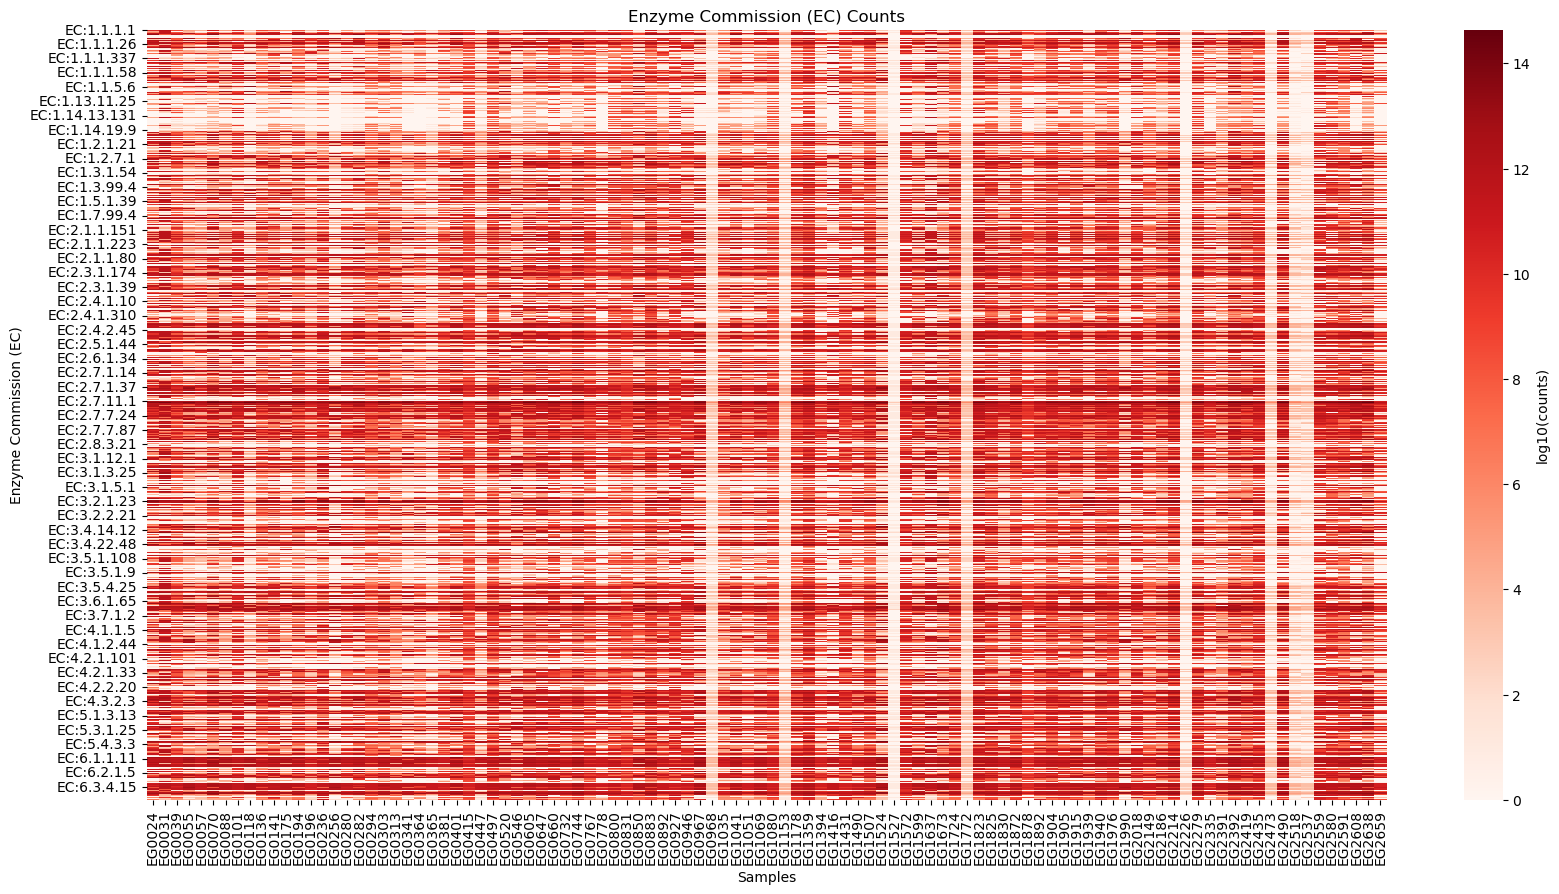

In [18]:
ec_log = np.log(ec + 1)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.heatmap(ec_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, ax=ax, xticklabels=ec_log.index)
g.set_title("Enzyme Commission (EC) Counts")
g.set_xlabel("Samples")
g.set_ylabel("Enzyme Commission (EC)")
g.figure.savefig(vis_dir / "ec_heatmap.png")


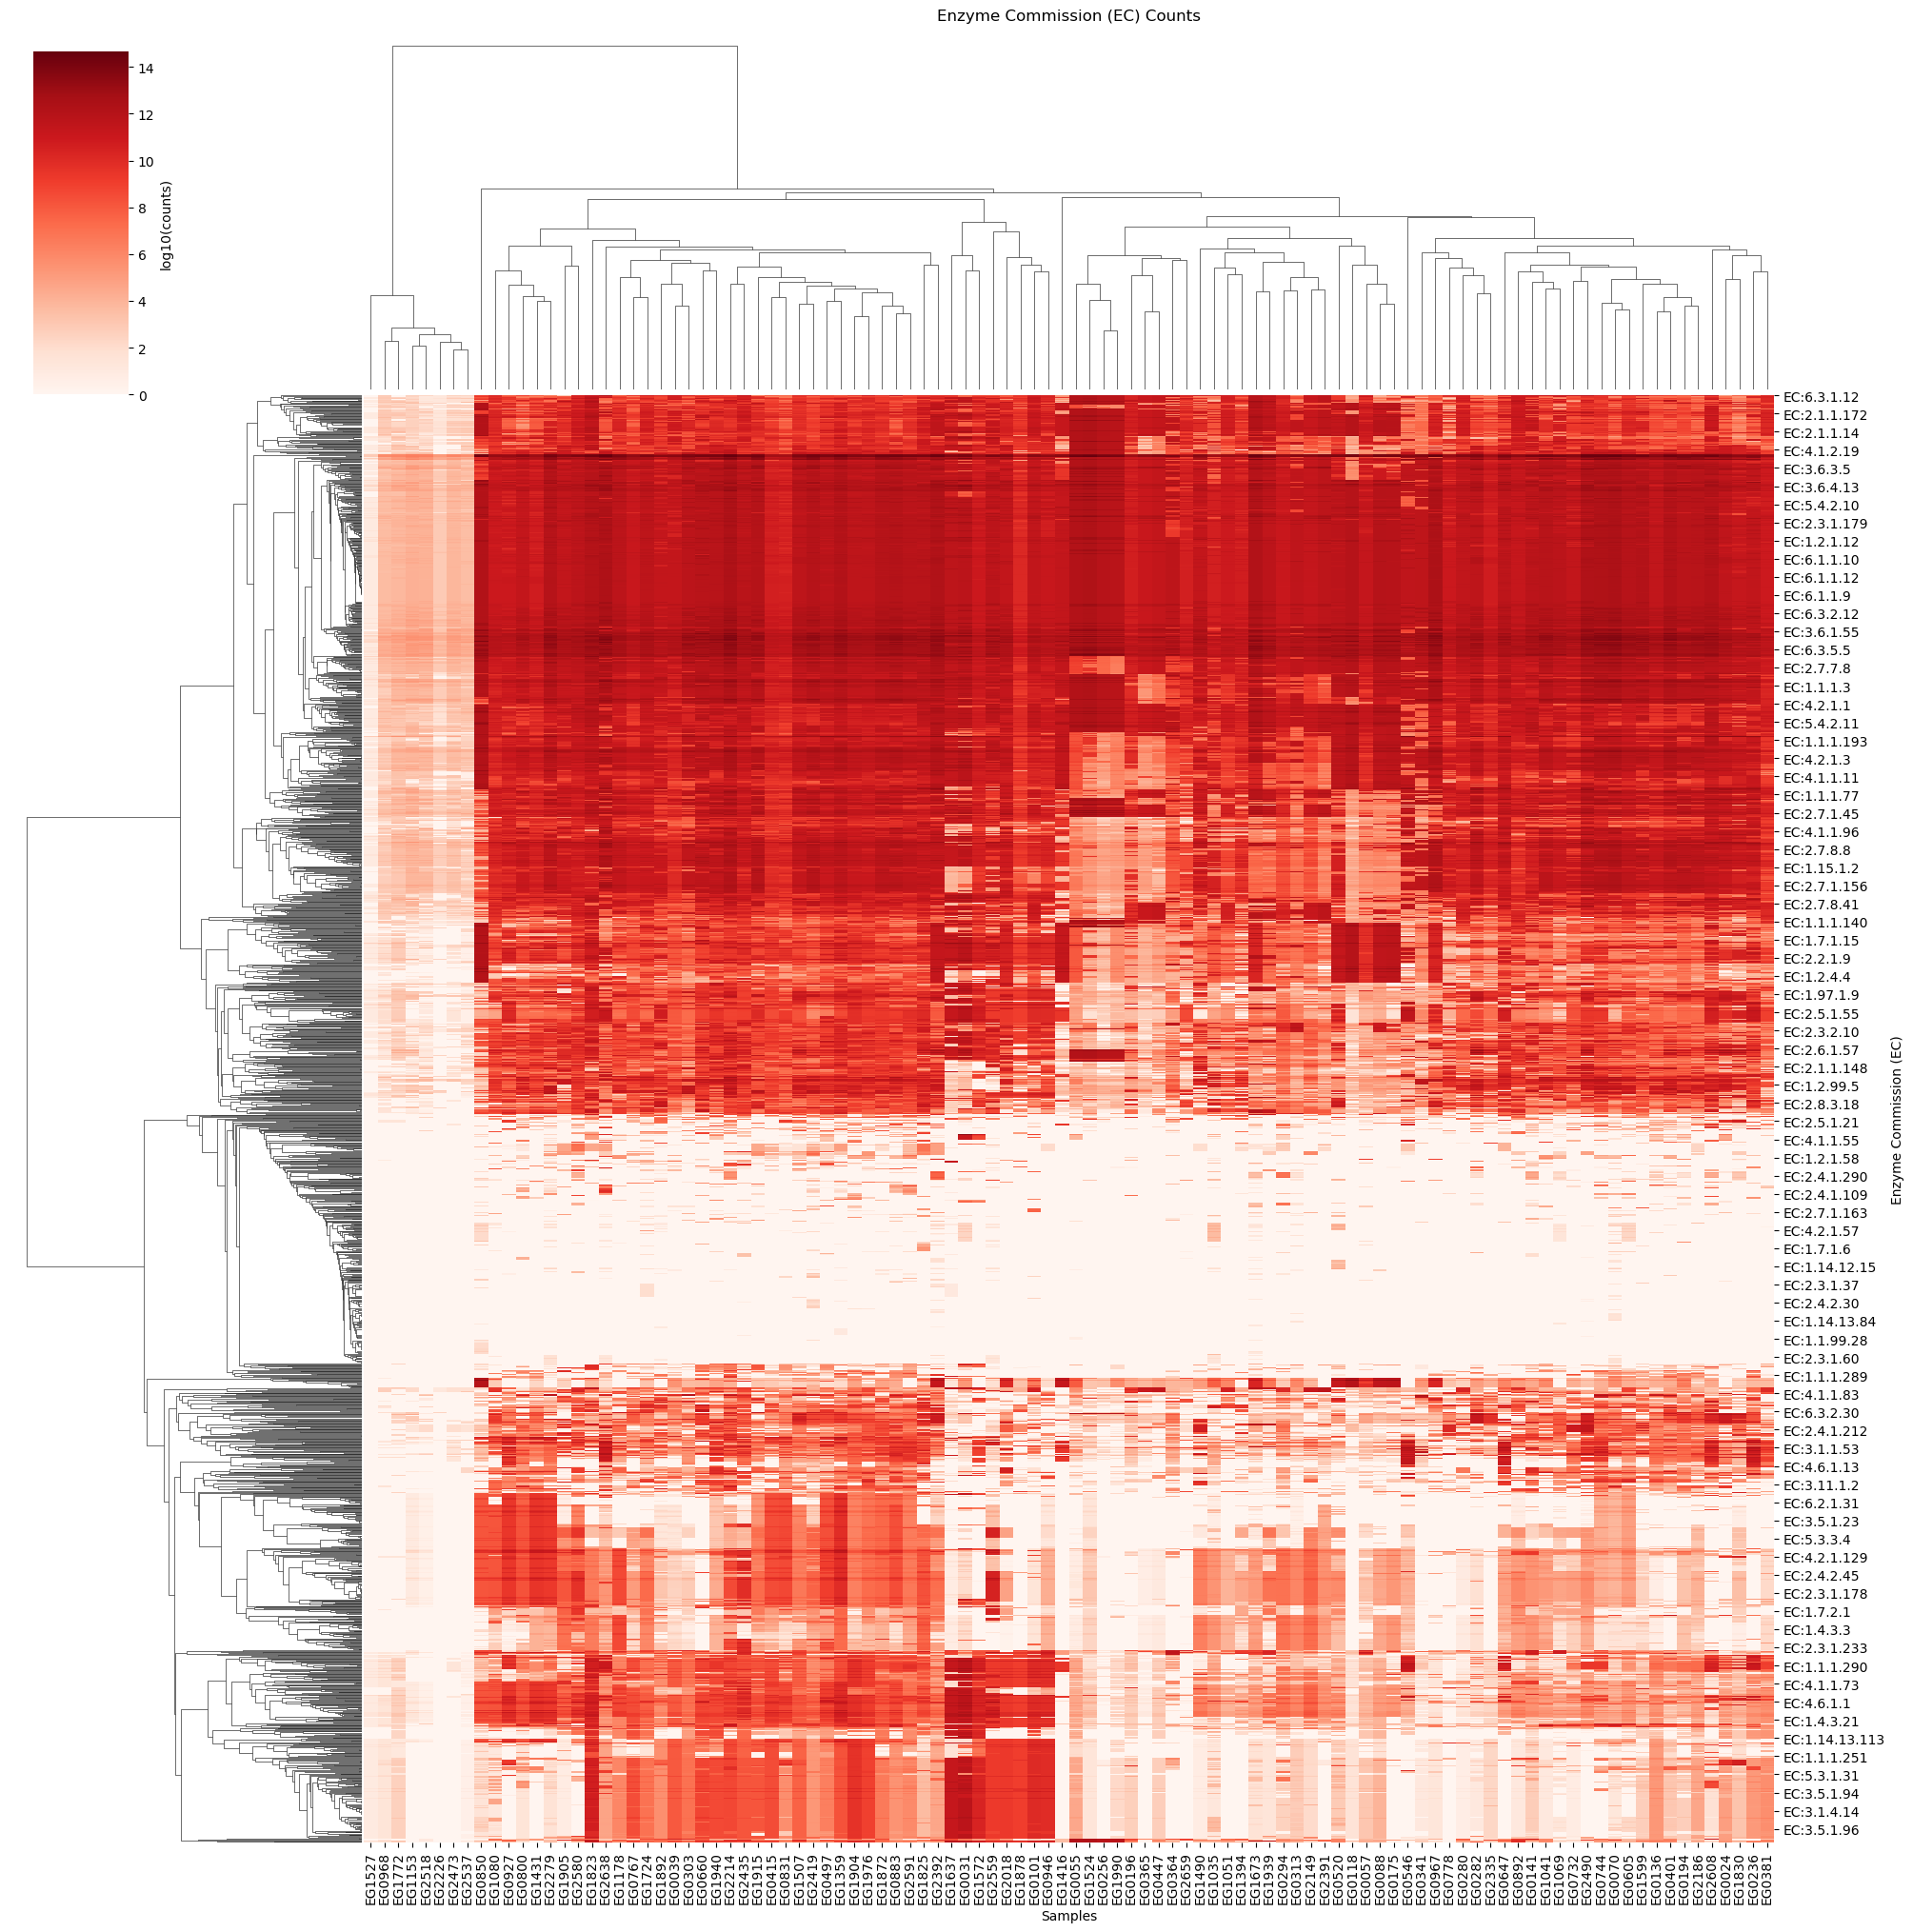

In [19]:
g = sns.clustermap(ec_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, figsize=(20, 20), xticklabels=ec_log.index)
g.ax_col_dendrogram.set_title("Enzyme Commission (EC) Counts")
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Enzyme Commission (EC)")
g.savefig(vis_dir / "ec_clustermap.png")


#### 3.3.3 MetaCyc pathways heatmap and clustermap

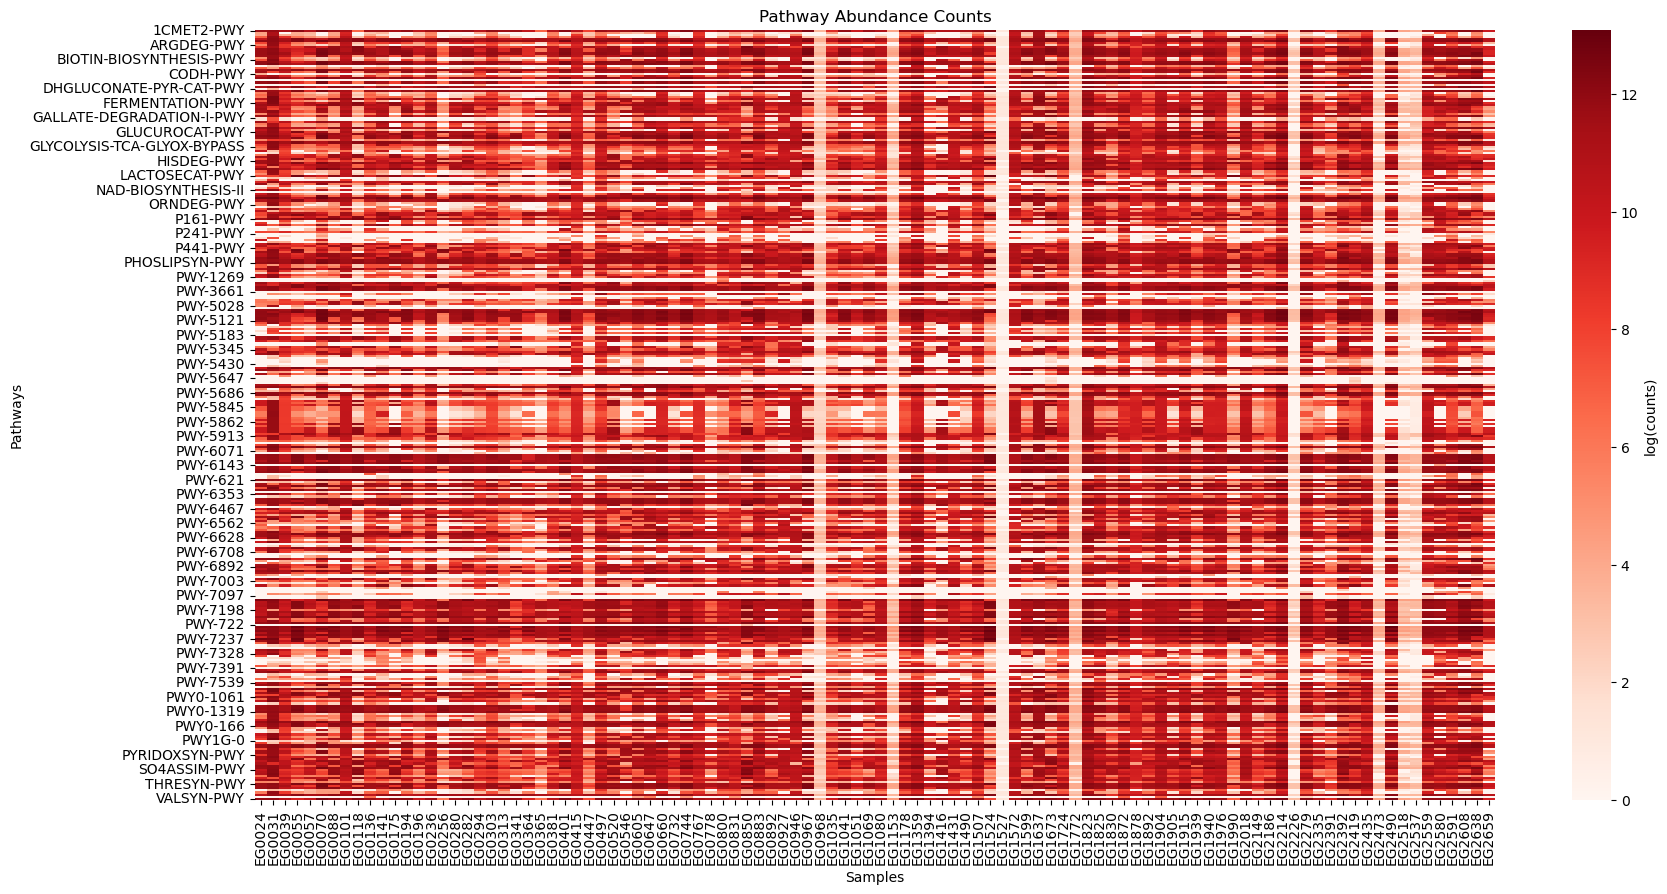

In [20]:
# visualize the data using a heatmap
pathabun_log = np.log(pathabun + 1)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.heatmap(pathabun_log.T, cmap="Reds", cbar_kws={'label': 'log(counts)'}, xticklabels=pathabun_log.index, ax=ax)
g.set_title("Pathway Abundance Counts")
g.set_xlabel("Samples")
g.set_ylabel("Pathways")
g.figure.savefig(vis_dir / "pathway_abundance_heatmap.png")


Hey, we see some samples with similar functional profiles. Let's try cluster map to see if we can find some patterns.

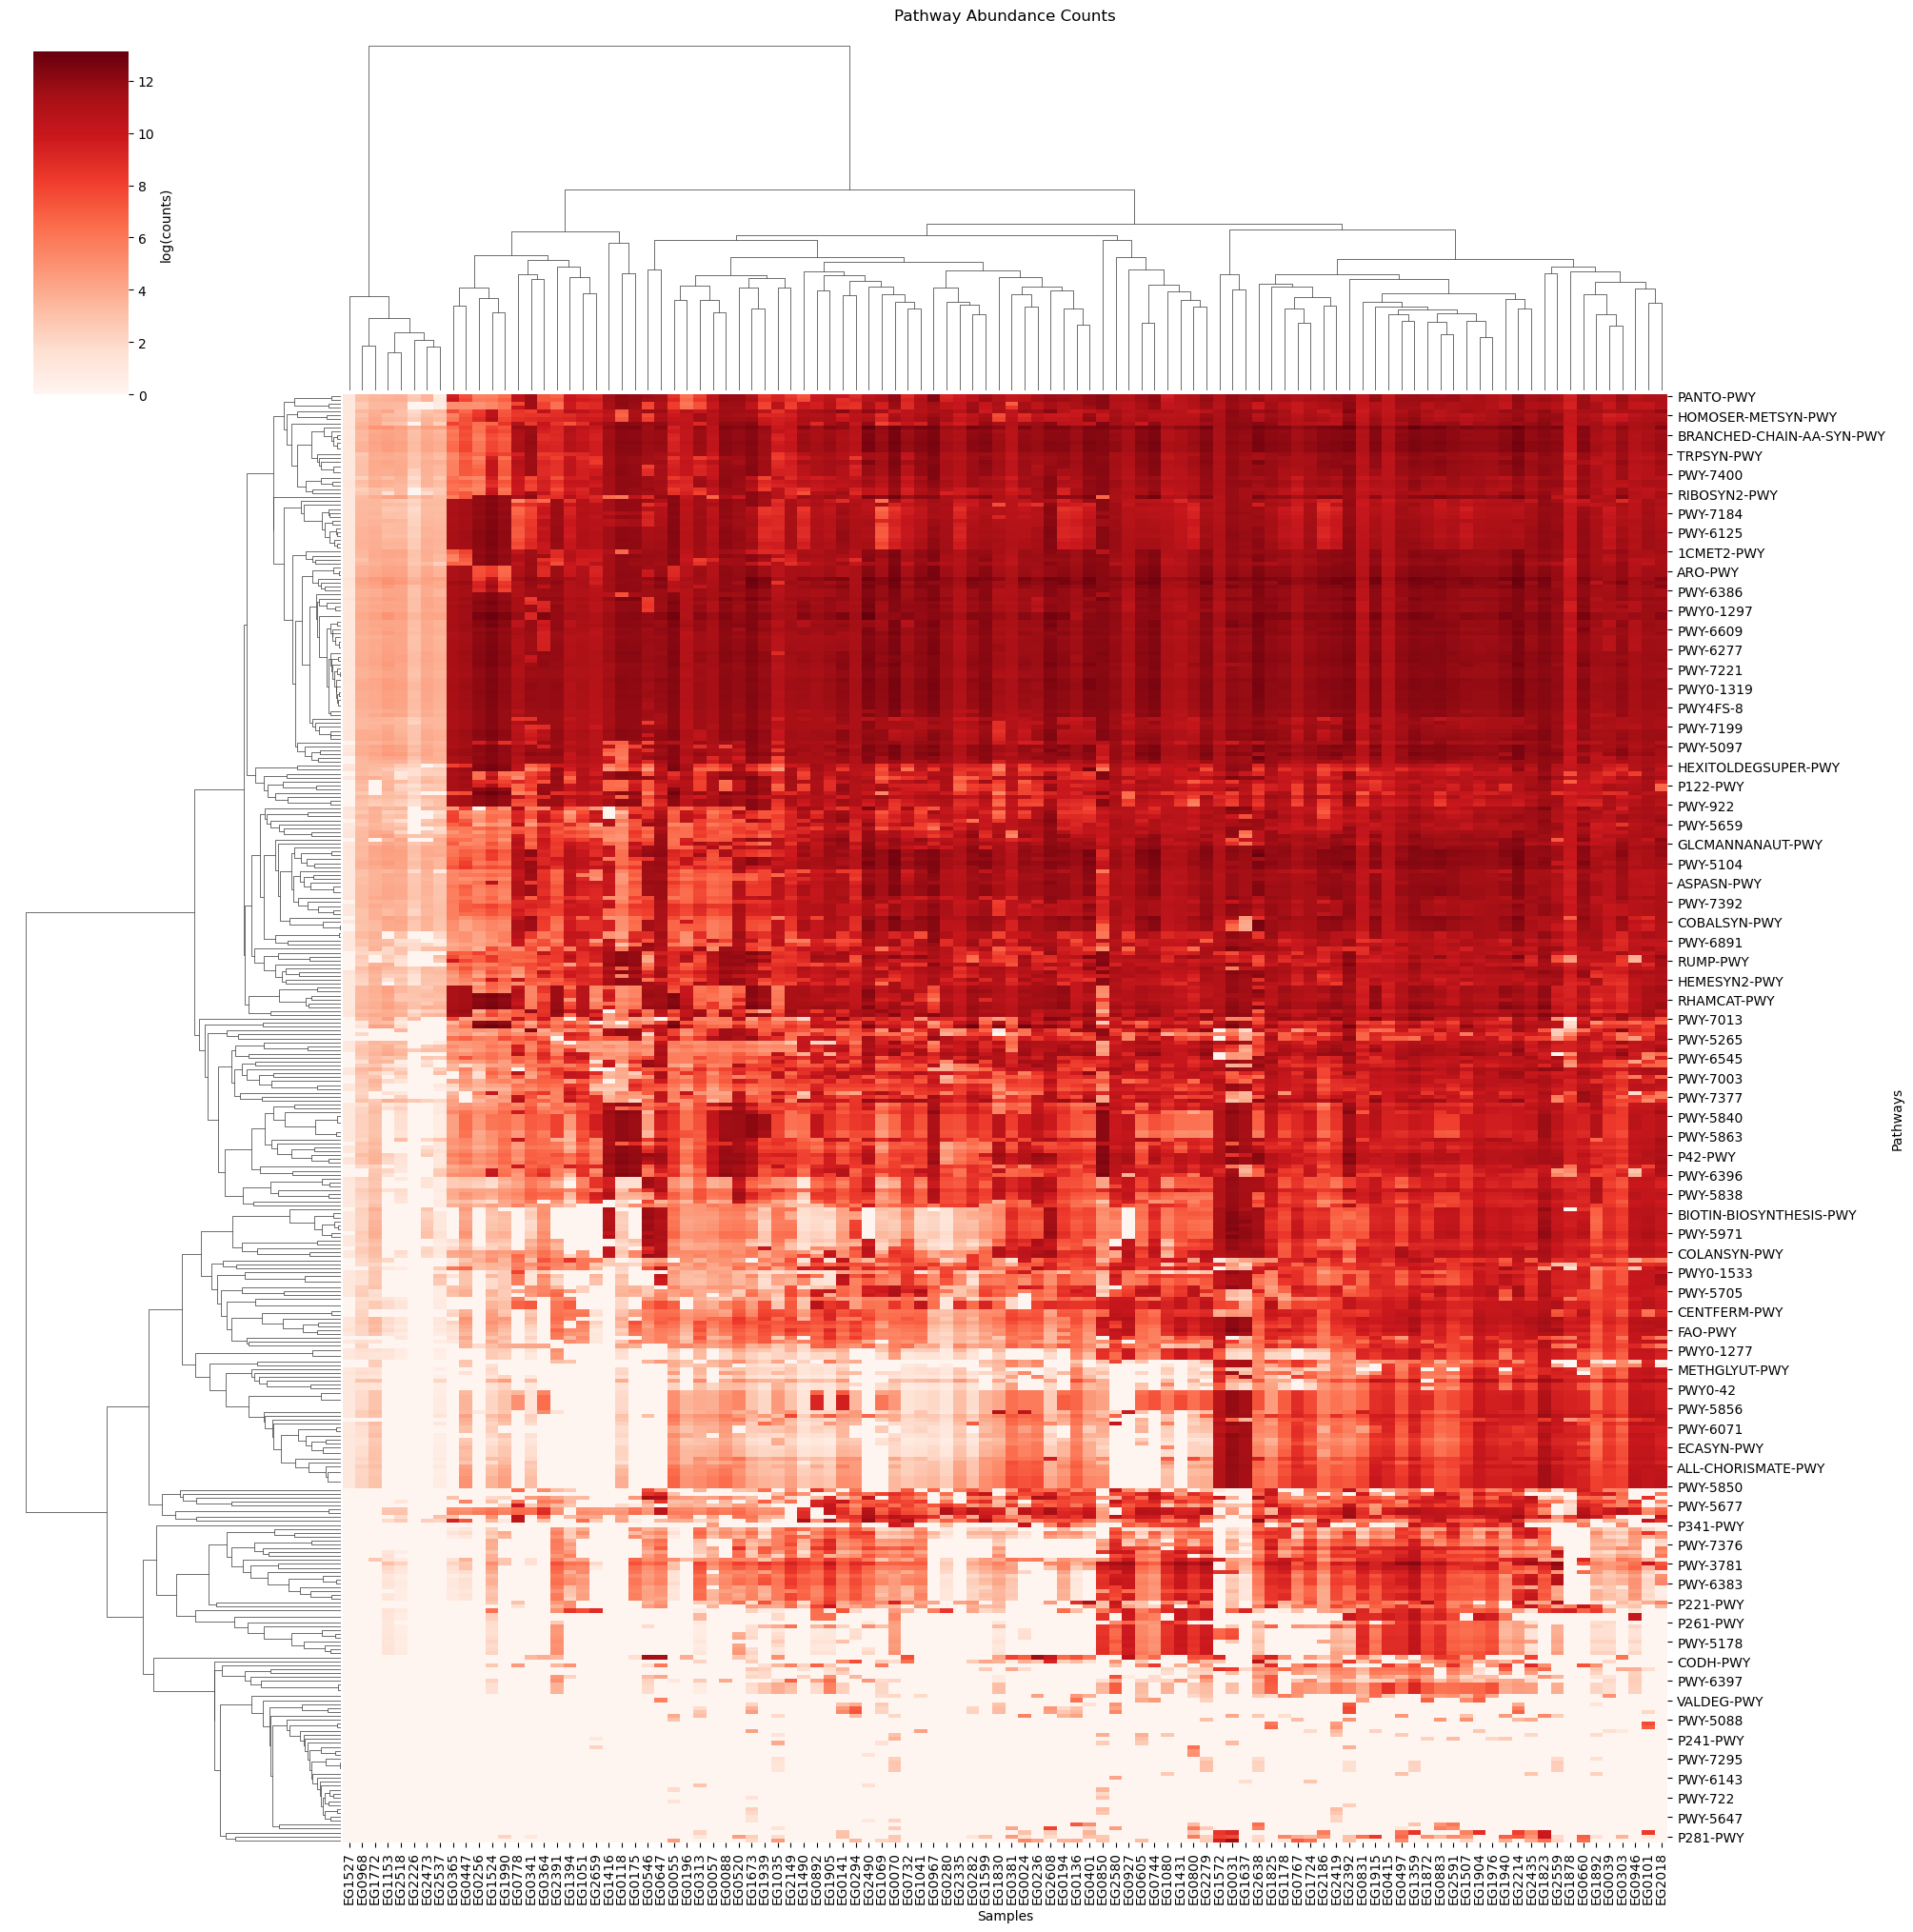

In [21]:
# visualize the data using a clustermap
g = sns.clustermap(pathabun_log.T, cmap="Reds", cbar_kws={'label': 'log(counts)'}, figsize=(20, 20), xticklabels=pathabun_log.index)
g.ax_col_dendrogram.set_title("Pathway Abundance Counts")
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Pathways")
g.savefig(vis_dir / "pathway_abundance_clustermap.png")


Seems like there is a cluster with relatively low abundance of pathways. 



The following code blocks tried to find whether there is any similarity in the metadata and taxonomical composition of the samples in the cluster. Both metadata and taxonomy of the samples in the cluster are not similar. This suggests that the different taxonomical composition and different patient can have similar functional profiles.

In [ ]:
meta = pd.read_csv(f"{data_dir}/metadata.tsv", sep="\t", index_col=0)
meta.reset_index(inplace=True)
samples = ["EG1527", "EG0968", "EG1772", "EG1153", "EG2518", "EG2226", "EG2473", "EG2537"]
meta_sub = meta.loc[meta["sample-id"].isin(samples)]
meta_sub

,sample-id,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
5,EG2473,P055,semi-formed,M,20,22.0,2
13,EG2226,P074,liquid,F,23,21.0,2
33,EG1772,P070,liquid,F,16,19.0,2
39,EG1527,P003,semi-formed,M,22,23.0,2
49,EG1153,P016,formed,F,22,24.0,2
56,EG0968,P047,liquid,M,0,59.0,1


In [77]:
taxa = q2.Artifact.load(f"{data_dir}/taxonomy.qza").view(pd.DataFrame)
taxa.head()

,Taxon,Confidence
Feature ID,,
65c81b7f020fa6530e5995cfadbed4b8,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.995352999769101
3b5167fc05d221e402cb1748506b8442,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9947820597188002
8b03f72e05e140685a739928d4dd2619,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9806855368923134
dc5e130892eb358854eb477a790f8af9,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,0.999971217732479
9b4ec0ce1b21a5a1172c2f0452d9f241,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,0.9999999999999716


In [80]:
features = q2.Artifact.load(f"{data_dir}/table-filtered.qza")
features = features.view(pd.DataFrame).transpose()
features.head()

,EG0024,EG0031,EG0039,EG0055,EG0057,EG0070,EG0088,EG0101,EG0118,EG0136,...,EG2473,EG2490,EG2518,EG2537,EG2559,EG2580,EG2591,EG2608,EG2638,EG2659
4755bc974c5753fb702d525dc1c03970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c8703d3d624bdfd6fa70431bf6ec2d5d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a17a009460b5d55c0bd0acbab9dfb98e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8828.0,0.0
119fc7a300c0fbd786dd1f4ef4d6476b,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5ab2232b49bd2e923a345f3f1fdf5ea7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# select only the samples of interest
features_sub = features.loc[:,samples]
features_sub

,EG1527,EG0968,EG1772,EG1153,EG2518,EG2226,EG2473,EG2537
4755bc974c5753fb702d525dc1c03970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c8703d3d624bdfd6fa70431bf6ec2d5d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a17a009460b5d55c0bd0acbab9dfb98e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119fc7a300c0fbd786dd1f4ef4d6476b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5ab2232b49bd2e923a345f3f1fdf5ea7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
42fa009bb25cff89306e3284a07556eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57d339f297021768f50e922416f0a972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7f584d41a22278d51dc518dd36aa6c48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36ae305da84d7a32e471d8629a2dd72d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
df = pd.concat([taxa, features_sub], axis=1)

In [79]:
def plot_taxonomic_abundance(df, ranks, color_map='Accent', sort_target='Firmicutes'):
    """
    Plots relative abundance stacked bar plots for each taxonomic rank in ranks.

    Parameters:
    - df: DataFrame containing taxonomic data with a 'Taxon' column and abundance columns for each sample.
    - ranks: List of taxonomic ranks to extract and plot (e.g., ["Phylum", "Class", "Order", "Family", "Genus", "Species"]).
    - color_map: Colormap to use for distinct colors (default is 'Accent').
    - sort_target: The taxonomic entry to use for sample sorting (default is 'Firmicutes').
    """
    # Extract each taxonomic rank from the 'Taxon' column
    for rank in ranks:
        df[rank] = df['Taxon'].str.extract(rf'{rank[:1].lower()}__([^;]+)')

    # Define a color palette using the specified color map
    colors = cm.get_cmap(color_map).colors

    # Loop over each taxonomic rank and generate the plot
    for rank in ranks:
        # Prepare data for the specific rank by dropping other rank columns
        data_for_plot = df.reset_index(drop=True).drop(columns=['Taxon', 'Confidence'] + [r for r in ranks if r != rank])

        # Sum values by the current rank level for each sample
        rank_sums = data_for_plot.groupby(rank).sum()

        # Convert to relative abundance for each sample
        rank_relative = rank_sums.div(rank_sums.sum(axis=0), axis=1) * 100

        # Sort samples by the abundance of the specified sort_target (e.g., 'Firmicutes') if available
        if sort_target in rank_relative.index:
            sorted_samples = rank_relative.loc[sort_target].sort_values(ascending=True).index
        else:
            sort_target = rank_relative.sum(axis=1).sort_values(ascending=False).index[0]
            sorted_samples = rank_relative.loc[sort_target].sort_values(ascending=True).index
        rank_relative_sorted = rank_relative[sorted_samples]

        # Order rank indices based on total abundance across all samples
        rank_total_abundance = rank_relative_sorted.sum(axis=1)
        rank_order = rank_total_abundance.sort_values(ascending=True).index
        rank_relative_sorted = rank_relative_sorted.reindex(rank_order)

        # Map colors to the ordered indices (reverse order for a visual gradient)
        rank_colors = {entry: colors[i % len(colors)] for i, entry in enumerate(rank_order[::-1])}

        # Plot with specified colormap colors for the current rank
        plt.figure(figsize=(15, 8))
        rank_relative_sorted.T.plot(
            kind='bar', stacked=True, figsize=(20, 10), width=0.8,
            color=[rank_colors[entry] for entry in rank_relative_sorted.index]
        )
        plt.xlabel("Sample", fontsize=14)
        plt.ylabel("Relative Abundance (%)", fontsize=14)
        plt.title(f"Relative Abundance of {rank} Across Samples", fontsize=18)
        plt.legend(title=rank, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"{vis_dir}/taxa-bar-plots-{rank}.png")

/tmp/ipykernel_34780/3850872949.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap(color_map).colors


<Figure size 1500x800 with 0 Axes>

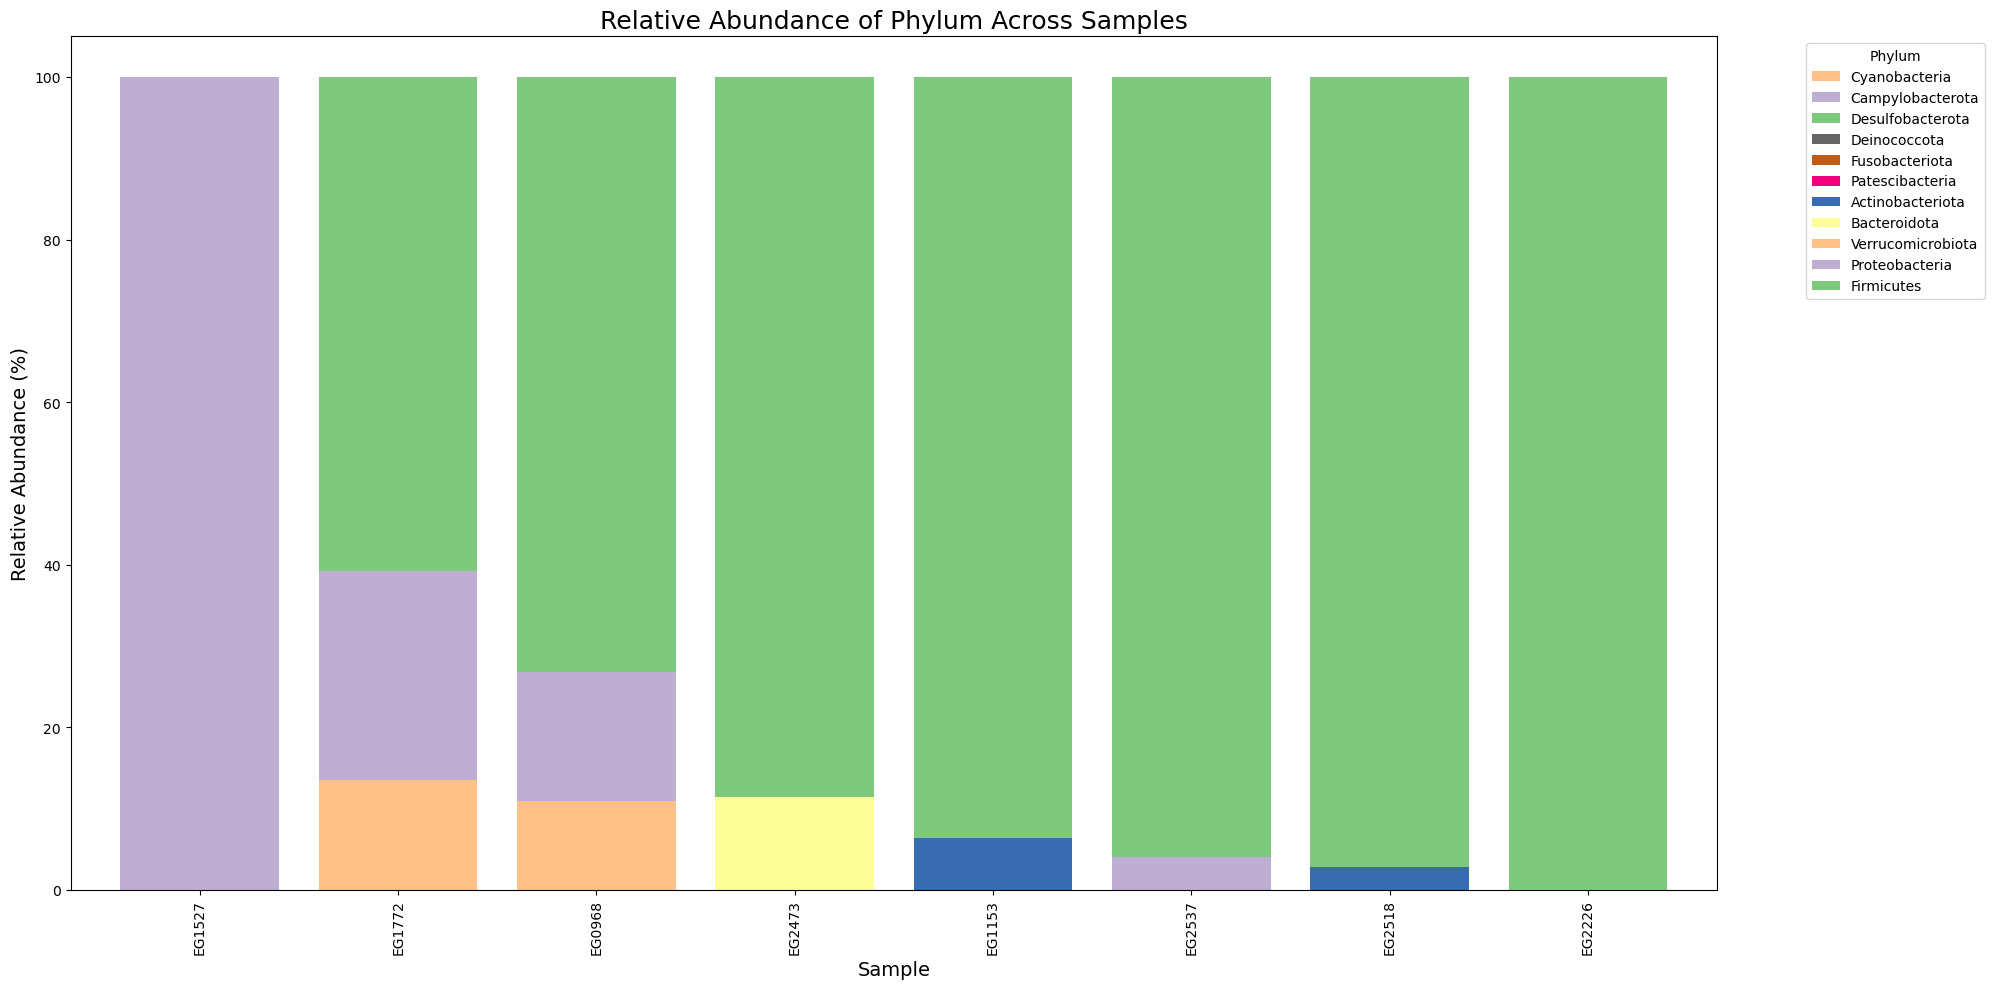

<Figure size 1500x800 with 0 Axes>

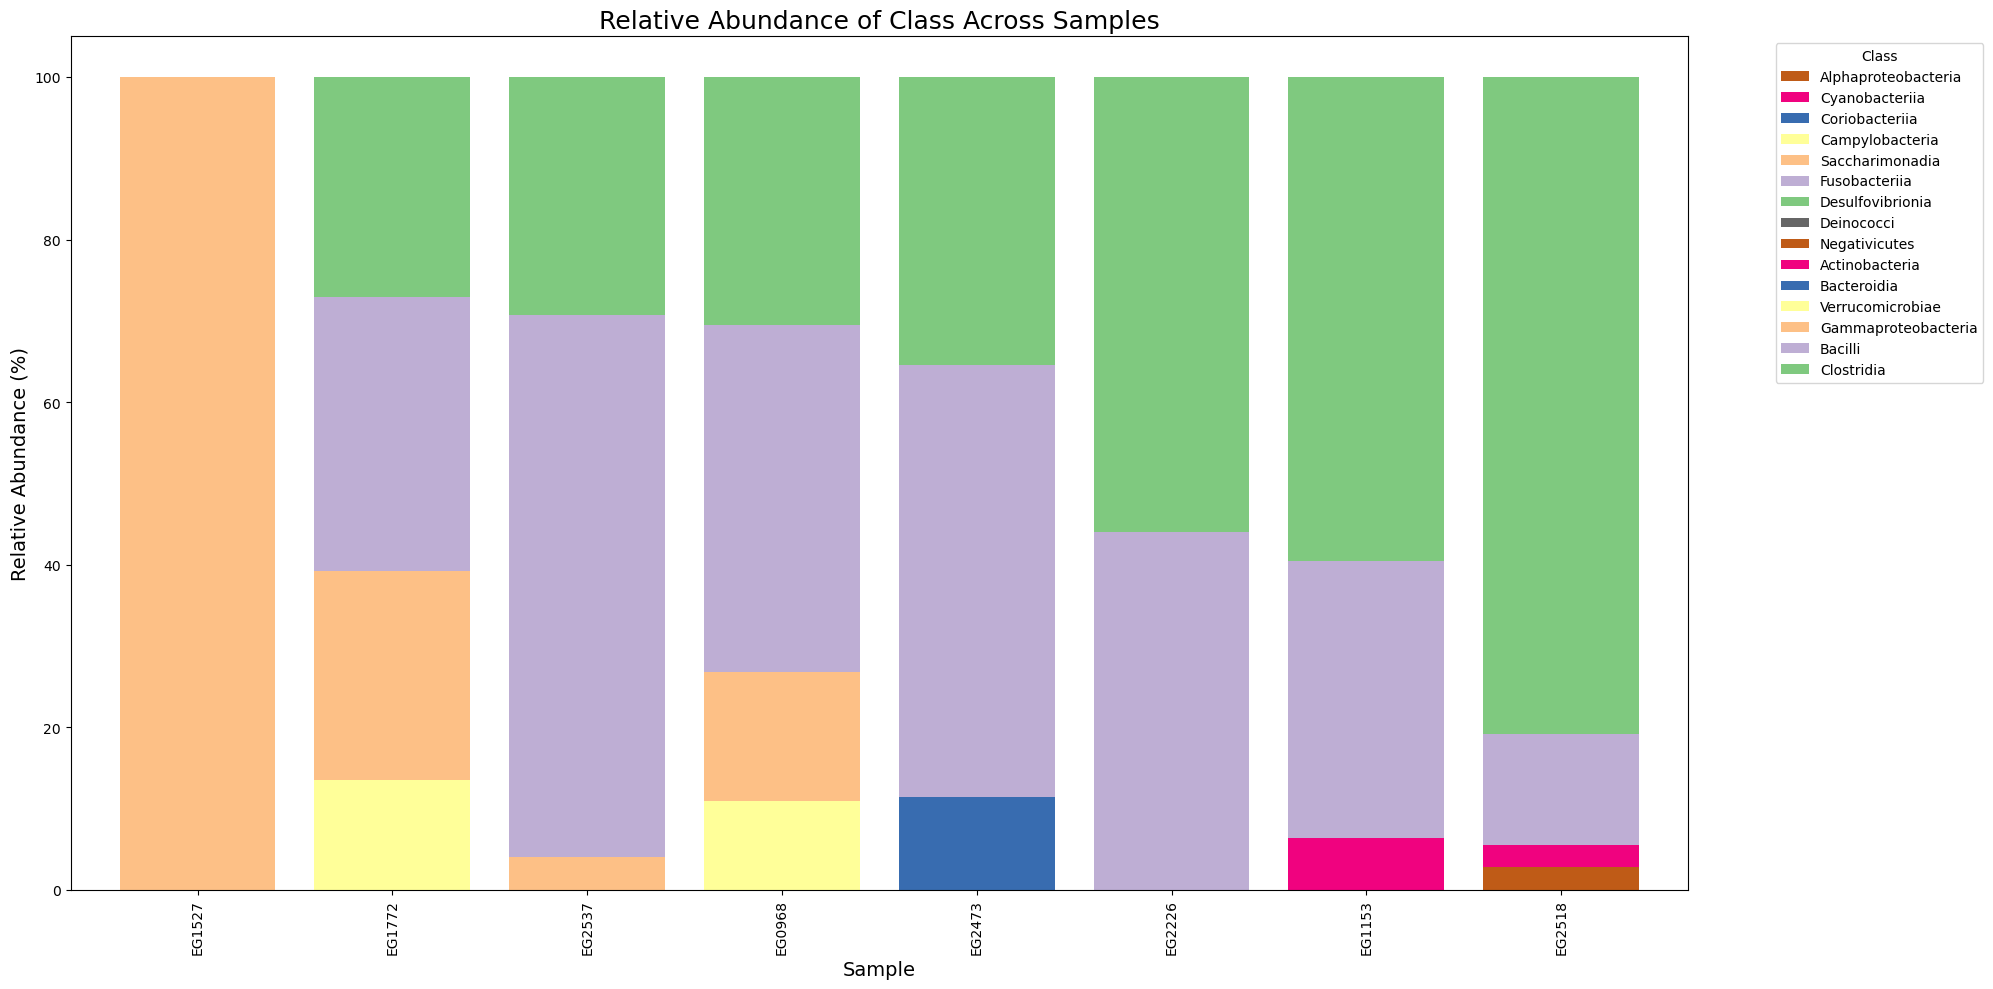

In [87]:
from matplotlib import cm
ranks = ["Phylum", "Class"]
plot_taxonomic_abundance(df, ranks)

### Beta correlation

In [117]:
! qiime diversity beta-correlation \
    --i-distance-matrix $data_dir/ko_metagenome_core_metrics/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_fillna.tsv \
    --m-metadata-column Recovery_Day \
    --p-intersect-ids \
    --o-metadata-distance-matrix $data_dir/ko_metagenome_core_metrics/spearman-recov-day.qza \
    --o-mantel-scatter-visualization $data_dir/ko_metagenome_core_metrics/scatter-plot-recov-day.qzv

Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/spearman-recov-day.qza
Saved Visualization to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/scatter-plot-recov-day.qzv


In [116]:
! qiime diversity beta-correlation \
    --i-distance-matrix $data_dir/pathway_abundance_core_metrics/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_fillna.tsv \
    --m-metadata-column Recovery_Day \
    --p-intersect-ids \
    --o-metadata-distance-matrix $data_dir/pathway_abundance_core_metrics/spearman-recov-day.qza \
    --o-mantel-scatter-visualization $data_dir/pathway_abundance_core_metrics/scatter-plot-recov-day.qzv

Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/pathway_abundance_core_metrics/spearman-recov-day.qza
Saved Visualization to: /home/matchy233/study/alien/data/processed/pathway_abundance_core_metrics/scatter-plot-recov-day.qzv


### 3.4 Differential Abundance between Cohorts

We can try to do some statistical tests to see if the patterns are significant. For example. between cohorts. We need to adjust the metadata a little bit to avoid ancom complaining "Cohort_Number" is numeric instead of categorical.

In [20]:
meta = pd.read_csv(f"{data_dir}/metadata.tsv", sep="\t", index_col=0)
meta["cohort"] = meta["Cohort_Number"].map({1: "Before abduction", 2: "After abduction"})
meta.to_csv(f"{data_dir}/metadata_categorical-cohort.tsv", sep="\t", index=True)

In [8]:
picrust_anal = Path(data_dir) / "pathabun_diffabun"
picrust_anal.mkdir(exist_ok=True)

In [46]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $picrust_res/pathway_abundance.qza \
    --m-metadata-file $data_dir/metadata_categorical-cohort.tsv \
    --p-formula cohort \
    --p-reference-levels "cohort::Before abduction" \
    --o-differentials $picrust_anal/ancombc_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $picrust_anal/ancombc_differentials.qza \
    --o-visualization $picrust_anal/ancombc_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $picrust_anal/ancombc_differentials.qza \
    --o-visualization $picrust_anal/ancombc_results.qzv

Saved FeatureData[DifferentialAbundance] to: /home/matchy233/study/alien/data/processed/pathabun_diffabun/ancombc_differentials.qza
Saved Visualization to: /home/matchy233/study/alien/data/processed/pathabun_diffabun/ancombc_da_barplot.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/pathabun_diffabun/ancombc_results.qzv


In [9]:
qza = picrust_anal / "ancombc_differentials.qza"
a = !unzip -o $qza
digest = Path(a[1].split('/')[0].replace("  inflating: ",""))
lfc = pd.read_csv(digest / "data" / "lfc_slice.csv")
qval = pd.read_csv(digest / "data" / "q_val_slice.csv")
!rm -r $digest


In [10]:
# merge the drop (Intercept) column from the lfc and qval dataframes and merge them
lfc_qval = pd.merge(lfc.drop("(Intercept)", axis=1), qval.drop("(Intercept)", axis=1), on="id")
lfc_qval = lfc_qval.rename(columns={
    "id": "pathway",
    "cohortAfter abduction_x": "log2foldchange",
    "cohortAfter abduction_y": "q-value"
})
lfc_qval.head()

,pathway,log2foldchange,q-value
0,1CMET2-PWY,-0.425241,1.0
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.020450,1.0
2,AEROBACTINSYN-PWY,-0.447109,1.0
3,ALL-CHORISMATE-PWY,-1.030912,1.0
4,ANAEROFRUCAT-PWY,0.389793,1.0


In [11]:
# save this dataframe as a csv file
lfc_qval.to_csv(f"{picrust_anal}/ancombc_results.csv", index=True)

In [55]:
lfc_qval_significant = lfc_qval[lfc_qval["q-value"] < 0.05]
lfc_qval_significant.head()

,pathway,log2foldchange,q-value
6,ARG+POLYAMINE-SYN,-1.127526,0.003732
12,ASPASN-PWY,-1.230605,0.000123
18,CENTFERM-PWY,-1.625897,0.000388
20,COBALSYN-PWY,-1.637630,0.000092
24,DAPLYSINESYN-PWY,-1.094884,0.000129


In [44]:
# top 10 most enriched pathways berfore abduction
lfc_qval_significant.sort_values("log2foldchange", ascending=False).head(10)

,pathway,log2foldchange,q-value
144,PWY-5347,-0.672922,0.026382
336,TRNA-CHARGING-PWY,-0.874502,0.006127
311,PWY0-781,-0.920050,0.000110
260,PWY-7211,-0.957862,0.004202
98,P4-PWY,-0.960622,0.000045
161,PWY-5695,-0.962903,0.002752
24,DAPLYSINESYN-PWY,-1.094884,0.000129
234,PWY-6737,-1.118068,0.000628
6,ARG+POLYAMINE-SYN,-1.127526,0.003732
129,PWY-5104,-1.128172,0.000850


It seems that there are no significantly enriched pathways after FDR correction compared to cohort 1.

In [45]:
# top 10 most depleted pathways berfore abduction
lfc_qval_significant.sort_values("log2foldchange", ascending=True).head(10)

,pathway,log2foldchange,q-value
71,METH-ACETATE-PWY,-3.053729,1.004840e-08
275,PWY-7332,-2.889324,2.581338e-03
74,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05
35,FUCCAT-PWY,-2.422689,1.664643e-09
255,PWY-7198,-2.396626,1.639304e-03
259,PWY-7210,-2.372636,2.498562e-03
158,PWY-5676,-2.369860,3.555472e-02
88,P162-PWY,-2.325231,1.902229e-03
162,PWY-5705,-2.304107,4.970931e-07
159,PWY-5677,-2.296525,4.348278e-04


But there are plenty of pathways that are significantly depleted in cohort 2 compared to cohort 1!

We try to translate the pathway identifier to meaningful names for better interpretation. To do this, we downloaded a mapping file from GitHub which was used in a metagenomics workshop in 2014 (it's a bit old)

In [59]:
! wget https://raw.githubusercontent.com/EnvGen/metagenomics-workshop/refs/heads/master/reference_db/metacyc/pwy.hierarchy -O $picrust_anal/pwy_hierarchy.txt

--2024-12-17 03:16:10--  https://raw.githubusercontent.com/EnvGen/metagenomics-workshop/refs/heads/master/reference_db/metacyc/pwy.hierarchy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270843 (264K) [text/plain]
Saving to: ‘/home/matchy233/study/alien/data/processed/pathabun_diffabun/pwy_hierarchy.txt’

/home/matchy233/stu 100%[===================>] 264.50K  --.-KB/s    in 0.07s   

2024-12-17 03:16:10 (3.74 MB/s) - ‘/home/matchy233/study/alien/data/processed/pathabun_diffabun/pwy_hierarchy.txt’ saved [270843/270843]



In [56]:
pwy_mapping = {}
pwy_mapping_hierarchy = {}
with open(f"{picrust_anal}/pwy_hierarchy.txt") as f:
    for line in f:
        line = line.strip()
        pwy = line.split("\t")[0]
        pwy_mapping[pwy] = line.split("\t")[1]
        pwy_mapping_hierarchy[pwy] = line.split("\t")[2]

In [58]:
# add name of the pathway to the dataframe
lfc_qval_significant.loc[:, "pathway_name"] = lfc_qval_significant["pathway"].map(pwy_mapping)
lfc_qval_significant.loc[:, "pathway_hierarchy"] = lfc_qval_significant["pathway"].map(pwy_mapping_hierarchy)
lfc_qval_significant.sort_values("log2foldchange", ascending=True).head(10)

,pathway,log2foldchange,q-value,pathway_name,pathway_hierarchy
71,METH-ACETATE-PWY,-3.053729,1.004840e-08,methanogenesis from acetate,Energy-Metabolism|METHANOGENESIS
275,PWY-7332,-2.889324,2.581338e-03,superpathway of UDP-<I>N</i>-acetylglucosamine...,Biosynthesis|Carbohydrates-Biosynthesis|CARBO-...
74,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05,NAD salvage pathway II,Biosynthesis|Cofactor-Biosynthesis|NAD-Metabol...
35,FUCCAT-PWY,-2.422689,1.664643e-09,fucose degradation,Degradation|Carbohydrates-Degradation|Sugars-A...
255,PWY-7198,-2.396626,1.639304e-03,pyrimidine deoxyribonucleotides <i>de novo</i>...,Biosynthesis|Nucleotide-Biosynthesis|Deoxyribo...
259,PWY-7210,-2.372636,2.498562e-03,pyrimidine deoxyribonucleotides biosynthesis f...,Biosynthesis|Nucleotide-Biosynthesis|PYR-NUC-S...
158,PWY-5676,-2.369860,3.555472e-02,acetyl-CoA fermentation to butyrate II,Fermentation|Acetyl-CoA-Butyrate
88,P162-PWY,-2.325231,1.902229e-03,glutamate degradation V (via hydroxyglutarate),Degradation|Amino-Acid-Degradation|GLUTAMATE-DEG
162,PWY-5705,-2.304107,4.970931e-07,allantoin degradation to glyoxylate III,Degradation|AMINE-DEG|Allantoin-degradation
159,PWY-5677,-2.296525,4.348278e-04,succinate fermentation to butyrate,Fermentation


In [89]:
lfc_qval_significant.sort_values("log2foldchange", ascending=True).head(10)["pathway_name"].values

array(['methanogenesis from acetate',
       'superpathway of UDP-<I>N</i>-acetylglucosamine-derived O-antigen building blocks biosynthesis',
       'NAD salvage pathway II', 'fucose degradation',
       'pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis IV',
       'pyrimidine deoxyribonucleotides biosynthesis from CTP',
       'acetyl-CoA fermentation to butyrate II',
       'glutamate degradation V (via hydroxyglutarate)',
       'allantoin degradation to glyoxylate III',
       'succinate fermentation to butyrate'], dtype=object)

In [59]:
# export the NaN values to a separate file for manual curation
lfc_qval_significant[lfc_qval_significant["pathway_name"].isna()].to_csv(f"{picrust_anal}/ancombc_results_nan.csv")

In [60]:
# split the pathway hierarchy into separate columns
lfc_qval_significant_temp = lfc_qval_significant["pathway_hierarchy"].str.split("|", expand=True)
# lfc_qval_significant_temp.columns = [f"level_{i}" for i in range(1, lfc_qval_significant_temp.shape[1] + 1)]
# lfc_qval_significant = pd.concat([lfc_qval_significant, lfc_qval_significant_temp], axis=1)
for i in range(0, lfc_qval_significant_temp.shape[0]):
    # from level 0 to 4, if the value is None, replace all lower levels with previous level
    for j in range(0, lfc_qval_significant_temp.shape[1]):
        if lfc_qval_significant_temp.iloc[i, j] is None:
            lfc_qval_significant_temp.iloc[i, j] = lfc_qval_significant_temp.iloc[i, j-1]
lfc_qval_significant_temp.columns = [f"level_{i}" for i in range(1, lfc_qval_significant_temp.shape[1] + 1)]
lfc_qval_significant = pd.concat([lfc_qval_significant, lfc_qval_significant_temp], axis=1)
lfc_qval_significant.head()


,pathway,log2foldchange,q-value,pathway_name,pathway_hierarchy,level_1,level_2,level_3,level_4,level_5
6,ARG+POLYAMINE-SYN,-1.127526,0.003732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,ASPASN-PWY,-1.230605,0.000123,superpathway of aspartate and asparagine biosy...,Biosynthesis|Amino-Acid-Biosynthesis,Biosynthesis,Amino-Acid-Biosynthesis,Amino-Acid-Biosynthesis,Amino-Acid-Biosynthesis,Amino-Acid-Biosynthesis
18,CENTFERM-PWY,-1.625897,0.000388,pyruvate fermentation to butanoate,Fermentation|Pyruvate-Degradation,Fermentation,Pyruvate-Degradation,Pyruvate-Degradation,Pyruvate-Degradation,Pyruvate-Degradation
20,COBALSYN-PWY,-1.637630,0.000092,adenosylcobalamin salvage from cobinamide I,Biosynthesis|Cofactor-Biosynthesis|Vitamin-Bio...,Biosynthesis,Cofactor-Biosynthesis,Vitamin-Biosynthesis,Cobalamin-Biosynthesis,Adenosylcobalamin-Biosynthesis
24,DAPLYSINESYN-PWY,-1.094884,0.000129,lysine biosynthesis I,Biosynthesis|Amino-Acid-Biosynthesis|IND-AMINO...,Biosynthesis,Amino-Acid-Biosynthesis,IND-AMINO-ACID-SYN,LYSINE-SYN,LYSINE-SYN


In [62]:
# drop NaN values
lfc_qval_significant_nona = lfc_qval_significant.dropna(subset=["pathway_name"])
lfc_qval_significant_nona.head()

,pathway,log2foldchange,q-value,pathway_name,pathway_hierarchy,level_1,level_2,level_3,level_4,level_5
12,ASPASN-PWY,-1.230605,1.234678e-04,superpathway of aspartate and asparagine biosy...,Biosynthesis|Amino-Acid-Biosynthesis,Biosynthesis,Amino-Acid-Biosynthesis,Amino-Acid-Biosynthesis,Amino-Acid-Biosynthesis,Amino-Acid-Biosynthesis
18,CENTFERM-PWY,-1.625897,3.881718e-04,pyruvate fermentation to butanoate,Fermentation|Pyruvate-Degradation,Fermentation,Pyruvate-Degradation,Pyruvate-Degradation,Pyruvate-Degradation,Pyruvate-Degradation
20,COBALSYN-PWY,-1.637630,9.226525e-05,adenosylcobalamin salvage from cobinamide I,Biosynthesis|Cofactor-Biosynthesis|Vitamin-Bio...,Biosynthesis,Cofactor-Biosynthesis,Vitamin-Biosynthesis,Cobalamin-Biosynthesis,Adenosylcobalamin-Biosynthesis
24,DAPLYSINESYN-PWY,-1.094884,1.291647e-04,lysine biosynthesis I,Biosynthesis|Amino-Acid-Biosynthesis|IND-AMINO...,Biosynthesis,Amino-Acid-Biosynthesis,IND-AMINO-ACID-SYN,LYSINE-SYN,LYSINE-SYN
35,FUCCAT-PWY,-2.422689,1.664643e-09,fucose degradation,Degradation|Carbohydrates-Degradation|Sugars-A...,Degradation,Carbohydrates-Degradation,Sugars-And-Polysaccharides-Degradation,Sugars-And-Polysaccharides-Degradation,Sugars-And-Polysaccharides-Degradation


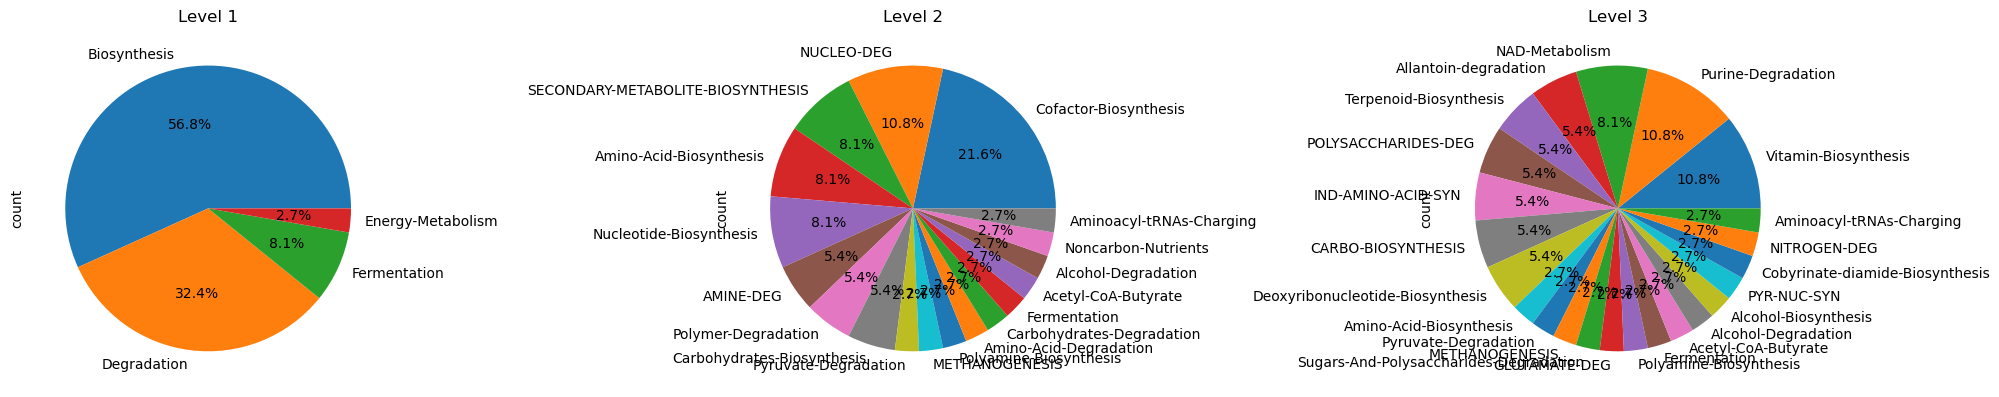

In [72]:
# visualize the pathway hierarchy at level 1 to 3 via pie charts, respectively
# use subplots to plot all pie charts in one figure
# in a 2x3 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i in range(1, 4):
    lfc_qval_significant_nona[f"level_{i}"].value_counts().plot.pie(ax=axs[i-1], autopct='%1.1f%%')
    axs[i-1].set_title(f"Level {i}")
plt.tight_layout()

In [38]:
SELECT = lfc_qval_significant["pathway_hierarchy"].fillna("Unclassified").map(
    lambda x: "amide" in x.lower()
)
lfc_qval_significant[SELECT]["pathway_hierarchy"].values

array(['Biosynthesis|Cofactor-Biosynthesis|Cobyrinate-diamide-Biosynthesis'],
      dtype=object)

In [100]:
df = pd.merge(meta, pathabun, left_on="sample-id", right_index=True)
df.head()

,sample-id,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number,1CMET2-PWY,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,AEROBACTINSYN-PWY,...,THISYN-PWY,THREOCAT-PWY,THRESYN-PWY,TRNA-CHARGING-PWY,TRPSYN-PWY,TYRFUMCAT-PWY,UBISYN-PWY,UDPNAGSYN-PWY,VALDEG-PWY,VALSYN-PWY
0,EG2580,P042,liquid,F,13,17.0,2,115456.015742,2623.771727,0.000000,...,43997.299917,4476.811153,106472.178816,114385.127765,80234.393078,3255.891100,0.000000,116138.218990,0.0,157994.142626
1,EG2559,P043,liquid,M,15,17.0,2,114168.155958,0.000000,60.398962,...,39046.647356,627.109498,138968.792940,111400.917596,133058.067153,65.257658,13563.965537,131352.899916,0.0,170367.024153
2,EG2537,P042,liquid,F,0,17.0,1,34.368817,0.000000,0.000000,...,1.590562,0.000000,25.123419,31.769026,25.277778,0.000000,1.066883,30.208906,0.0,44.878574
3,EG2518,P043,liquid,M,0,17.0,1,59.120553,0.000000,0.000000,...,6.696096,0.000000,56.321713,62.990315,42.869123,0.873533,0.000000,31.040516,0.0,69.927922
4,EG2490,P030,formed,F,0,NaN,1,167742.073431,0.000000,0.000000,...,71390.972784,714.497686,189201.693798,222469.372769,94625.844694,320.062795,0.000000,176193.176976,0.0,288821.769267


In [101]:
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import linregress
import itertools
from statsmodels.stats.multitest import multipletests

In [ ]:
# Define function to calculate Spearman correlation
def calculate_spearman_correlation(taxonomic_composition, exclude_columns):
    # Filter the rows where Cohort_Number equals 1 and drop NaN in 'Recovery_Day'
    tax_comp_pretransplant = taxonomic_composition[taxonomic_composition['Cohort_Number'] == 1]
    tax_comp_pretransplant_clean = tax_comp_pretransplant.dropna(subset=['Recovery_Day'])

    # Get columns to correlate
    columns_to_correlate = [col for col in tax_comp_pretransplant_clean.columns if col not in exclude_columns]

    # Calculate Spearman correlation for each column
    correlation_results = []
    for column in columns_to_correlate:
        if tax_comp_pretransplant_clean[column].nunique() == 1:
            corr, p_value = float('nan'), float('nan')
            sample_size = 0
        else:
            corr, p_value = spearmanr(tax_comp_pretransplant_clean['Recovery_Day'], tax_comp_pretransplant_clean[column])
            sample_size = tax_comp_pretransplant_clean[['Recovery_Day', column]].dropna().shape[0]

        correlation_results.append({
            'correlated_column': column,
            'correlation': corr,
            'p_value': p_value,
            'sample_size': sample_size
        })

    return pd.DataFrame(correlation_results)


all_correlation_results_df = calculate_spearman_correlation(df, ['sample-id', 'Cohort_Number', 'Recovery_Day', 'Patient_ID', 'Stool_Consistency', 'Patient_Sex', 'Sample_Day'])
all_correlation_results_df.head()


,correlated_column,correlation,p_value,sample_size
0,1CMET2-PWY,0.045240,0.752585,51
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.139684,0.328264,51
2,AEROBACTINSYN-PWY,0.185906,0.191504,51
3,ALL-CHORISMATE-PWY,0.103232,0.470983,51
4,ANAEROFRUCAT-PWY,-0.000181,0.998992,51


In [110]:

# ---- Filter and Sort Results ----
# Filter and sort the results by p-value
all_correlation_results_filtered = all_correlation_results_df.dropna(subset=['p_value'])
all_correlation_results_filtered.head()


,correlated_column,correlation,p_value,sample_size
0,1CMET2-PWY,0.045240,0.752585,51
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.139684,0.328264,51
2,AEROBACTINSYN-PWY,0.185906,0.191504,51
3,ALL-CHORISMATE-PWY,0.103232,0.470983,51
4,ANAEROFRUCAT-PWY,-0.000181,0.998992,51


In [111]:


# Perform Benjamini-Hochberg FDR correction on the p-values
from statsmodels.stats.multitest import multipletests

# Extract p-values for correction
p_values = all_correlation_results_filtered['p_value'].values

# Apply FDR correction
rejected, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add corrected p-values to the DataFrame
all_correlation_results_filtered['corrected_p_value'] = corrected_p_values
all_correlation_results_filtered.head()


/tmp/ipykernel_34780/2369999726.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_correlation_results_filtered['corrected_p_value'] = corrected_p_values


,correlated_column,correlation,p_value,sample_size,corrected_p_value
0,1CMET2-PWY,0.045240,0.752585,51,0.998992
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.139684,0.328264,51,0.998992
2,AEROBACTINSYN-PWY,0.185906,0.191504,51,0.998992
3,ALL-CHORISMATE-PWY,0.103232,0.470983,51,0.998992
4,ANAEROFRUCAT-PWY,-0.000181,0.998992,51,0.998992


In [113]:


# Filter significant results before and after correction
significant_results_raw = all_correlation_results_filtered[all_correlation_results_filtered['p_value'] < 0.05]
significant_results_corrected = all_correlation_results_filtered[all_correlation_results_filtered['corrected_p_value'] < 0.05]

# ---- Save Results ----
# Save the uncorrected and corrected results to separate Excel sheets
significant_results_raw_sorted = significant_results_raw.sort_values('p_value')
significant_results_corrected_sorted = significant_results_corrected.sort_values('corrected_p_value')

significant_results_raw_sorted

,correlated_column,correlation,p_value,sample_size,corrected_p_value


## 4. Thoughts and Discussion

Although amplicon-based predictions may be highly correlated with functional profiles based on shotgun metagenomics sequencing data, differential abundance results will likely differ substantially from what would be found based on shotgun metagenomics data. As we requested data from our TA, it is important to compare the results generated from shotgun metagenomics analysis with the prediction from picrust.

## Bibliography

[1] G. M. Douglas et al., “PICRUSt2 for prediction of metagenome functions,” Nature Biotechnology, vol. 38, no. 6, pp. 685–688, Jun. 2020, doi: https://doi.org/10.1038/s41587-020-0548-6.

‌[2] S. Purushothaman, M. Meola, and A. Egli, “Combination of Whole Genome Sequencing and Metagenomics for Microbiological Diagnostics,” International Journal of Molecular Sciences, vol. 23, no. 17, p. 9834, Aug. 2022, doi: https://doi.org/10.3390/ijms23179834.
‌